# Spearman

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from igraph import Graph

In [80]:
def filter_cases(list_cases_name, min_cases):
    df = pd.read_csv(
        list_cases_name,
        encoding='utf-8',
        sep=',',
        usecols=['ibgeID', 'newCases', 'totalCases', 'date'],
        dtype={'ibgeID': int}
    )
    filtered_df = df[(df['totalCases'] >= min_cases) & (df['newCases'] >= 1) & (df['ibgeID'] > 1000)]
    filtered_df = filtered_df.drop_duplicates(subset='ibgeID')
    return filtered_df


In [6]:
graph = Graph.Read_GraphML("/content/drive/MyDrive/Colab Notebooks/IC/Datas/networks/grafo_Peso_Geral.GraphML")
geocodes = list(map(int, graph.vs["geocode"]))
degrees = graph.degree()
clustering = graph.transitivity_local_undirected()
strength = graph.strength(weights="weight")
graph.es['w_inv'] = 1.0 / np.array(graph.es['weight'])
weighted_betweenness = graph.betweenness(vertices=None, directed=False, cutoff=None, weights='w_inv')
weighted_closeness = graph.closeness(vertices=None, mode='all', cutoff=None, weights='w_inv', normalized=True)
weighted_eignv = graph.evcent(directed=False, scale=True, weights='w_inv', return_eigenvalue=False)

metrics_df = pd.DataFrame({
    "geocode": geocodes,
    "degree": degrees,
    "clustering": clustering,
    "strength": strength,
    "Weighted_betweenness": weighted_betweenness,
    "Weighted_closeness": weighted_closeness,
    "Weighted_eignv": weighted_eignv
})

<ipython-input-6-fc340ed3bab0>:1: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:488
  graph = Graph.Read_GraphML("/content/drive/MyDrive/Colab Notebooks/IC/Datas/networks/grafo_Peso_Geral.GraphML")


In [30]:
metrics_df

,geocode,degree,clustering,strength,Weighted_betweenness,Weighted_closeness,Weighted_eignv
0,1302603,73,0.088661,4404.5,262625.0,26.176193,0.008371
1,1304260,5,1.000000,90.5,0.0,15.141611,0.000094
2,1302108,3,1.000000,77.0,0.0,14.840713,0.000115
3,5103809,12,0.818182,1566.0,10474.0,35.938431,0.001339
4,5108402,106,0.295597,5770.0,35617.0,37.027813,0.091256
...,...,...,...,...,...,...,...
5380,2111722,1,NaN,7.0,0.0,5.552964,0.002172
5381,2205359,1,NaN,7.0,0.0,5.857899,0.000254
5382,5104526,1,NaN,14.0,0.0,10.166832,0.000849
5383,5106240,1,NaN,21.0,0.0,13.413105,0.000566


In [67]:
# filter_cases
min_cases = 1
list_cases_name = "/content/drive/MyDrive/Colab Notebooks/IC/Datas/Pre-processed/cases-brazil-cities-time_2020.csv"
df = filter_cases(list_cases_name, min_cases)

In [68]:
df

,date,ibgeID,newCases,totalCases
0,2020-02-25,3550308,1,1
18,2020-03-05,3300407,1,1
24,2020-03-06,2910800,1,1
25,2020-03-06,3304557,1,1
29,2020-03-07,5300108,1,1
...,...,...,...,...
906771,2020-10-20,3110400,1,1
945744,2020-10-27,3108503,3,3
1006076,2020-11-06,3165206,1,1
1043883,2020-11-13,3149408,1,1


In [69]:
df = df.merge(metrics_df, left_on='ibgeID', right_on='geocode')
df = df.sort_values(by=['date', 'ibgeID'])

In [58]:
df

,date,ibgeID,newCases,totalCases,geocode,degree,clustering,strength,Weighted_betweenness,Weighted_closeness,Weighted_eignv
0,2020-02-25,3550308,1,1,3550308,1461,0.024956,76190.875,2037696.0,39.141769,1.000000e+00
1,2020-03-05,3300407,1,1,3300407,102,0.201320,3610.000,21465.0,31.706427,8.099974e-02
2,2020-03-06,2910800,1,1,2910800,436,0.090077,23365.250,474521.0,38.472125,3.167386e-01
3,2020-03-06,3304557,1,1,3304557,461,0.072008,25986.000,606835.0,37.052771,4.054624e-01
5,2020-03-07,3547304,1,1,3547304,1,NaN,14.000,0.0,9.895418,3.918752e-05
...,...,...,...,...,...,...,...,...,...,...,...
5380,2020-10-12,3171071,1,1,3171071,16,0.925000,1099.000,18552.0,34.681748,7.302178e-04
5381,2020-10-20,3110400,1,1,3110400,1,NaN,288.000,0.0,33.624877,4.118042e-07
5382,2020-10-27,3108503,3,3,3108503,3,1.000000,177.000,0.0,29.432680,2.417877e-03
5383,2020-11-06,3165206,1,1,3165206,6,0.600000,285.000,0.0,23.174141,6.657575e-04


In [83]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df.ibgeID.tolist())

def calculate_sequence(df, metric):
    sorted_df = df.sort_values(metric, ascending=False)
    return le.transform(sorted_df['geocode'].tolist())

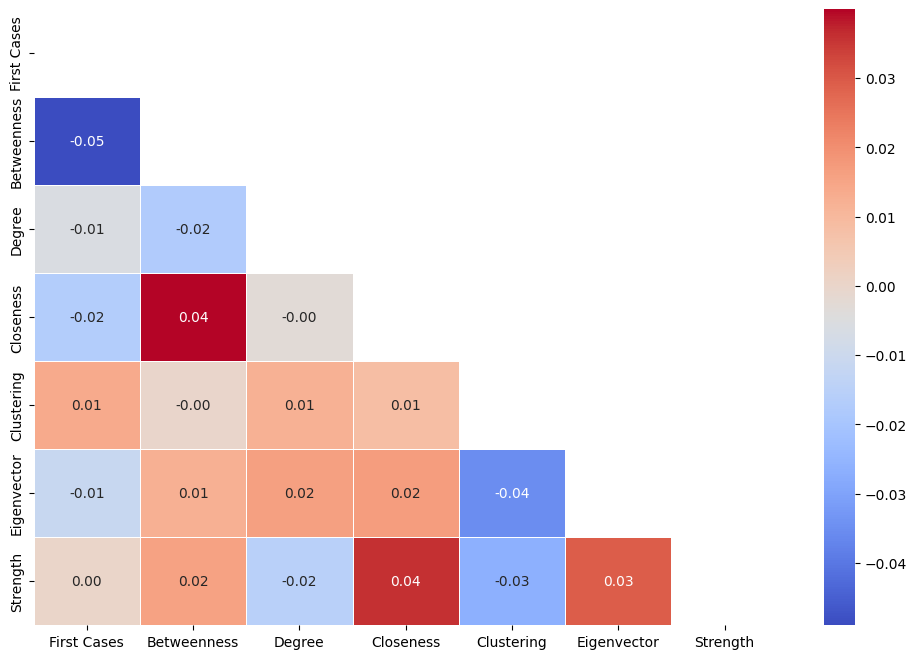

In [84]:
# Inicializar df_seq
df_seq = pd.DataFrame({
    'Degree Sequence':calculate_sequence(df, 'degree'),
    'Clustering Sequence':calculate_sequence(df, 'clustering'),
    'Strength Sequence':calculate_sequence(df, 'strength'),
    'Betweenness Sequence':calculate_sequence(df, 'Weighted_betweenness'),
    'Closeness Sequence':calculate_sequence(df, 'Weighted_closeness'),
    'Eigenvector Sequence':calculate_sequence(df, 'Weighted_eignv'),
    'Cases Sequence':le.transform(df['ibgeID'].tolist()),
    })

# Construir o DataFrame para correlação
df_corr = pd.DataFrame({
    'First Cases': df_seq['Cases Sequence'],
    'Betweenness': df_seq['Betweenness Sequence'],
    'Degree': df_seq['Degree Sequence'],
    'Closeness': df_seq['Closeness Sequence'],
    'Clustering': df_seq['Clustering Sequence'],
    'Eigenvector': df_seq['Eigenvector Sequence'],
    'Strength': df_seq['Strength Sequence'],
})

# Calcular a matriz de correlação usando o coeficiente de Spearman
corr = df_corr.corr(method='spearman')

# Criar a máscara para a parte superior da matriz de correlação
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plotar o heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/IC/Correlation_Spearman.pdf', bbox_inches='tight')
plt.show()